In [1]:
input('Warning: contains solution spoilers. Press enter to continue.')
import numpy as np
import matplotlib.pyplot as plt

# Problem set 3
## Question1
Part a

In [2]:
def diffusion_FE(phi_fn, k=1, dx=1, L=100, dt=0.01, T=50, snapshots=[], f=None):
    ''' Diffusion equation dphi/dt = k d^2phi/dx^2 + f(x,t) 
    BC: phi(0) = phi(L) = 0
    Forcing f
    
    Given initial condition phi_fn(np.array -> np.array), solve the
    diffusion equation using forward Euler with coef k on domain [0,L]
    with grid space dx. Simulate to time T with timestep dt. Save
    extra snapshots as a list of indices.'''
    if dt >= dx**2/(2*k):
        print("Unstable, check dt")
    if f is None:
        f = lambda x, t: 0
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, L+dx, dx, dtype=np.float64)
    
    # IC
    phi = np.array(phi_fn(x), dtype=np.float64)
    
    phi_list = []
    ts = []
    
    n = len(x)
    dtdx = k*dt/dx**2
    
    # Matrix for FE
    M = (1-2*dtdx)*np.identity(n) + \
        dtdx*np.diag([1]*(n-1), 1) + \
        dtdx*np.diag([1]*(n-1), -1)
    
    # Enforce BC
    M[0,0], M[n-1,n-1] = 0., 0.

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi)
            ts.append(t)
        phi = M@phi  # FE step
        phi += dt*f(x, t) # Add forcing

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return x, ts, phi_list

def plot_phis(x, ts, phi_list):
    colors = plt.cm.magma(np.linspace(0, 1, len(phi_list)))
    for i, phi in enumerate(phi_list):
        plt.plot(x, phi, label=f"{ts[i]:.2f}", color=colors[i])
    plt.legend(loc='upper right')


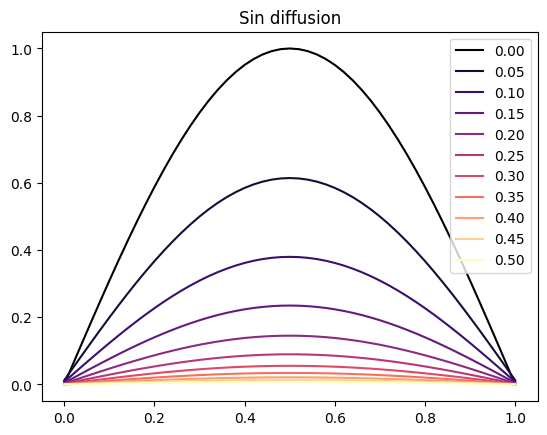

In [3]:
ic = lambda x: np.sin(np.pi*x)
out = diffusion_FE(ic, k=1, dx=1/50, L=1, dt=1e-4, T=.5, snapshots=10)
plt.title("Sin diffusion")
plot_phis(*out)

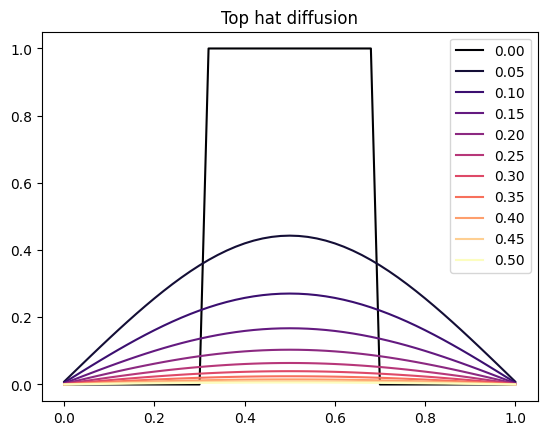

In [4]:
ic = lambda x: (x>.3)*(x<.7)
out = diffusion_FE(ic, k=1, dx=1/50, L=1, dt=1e-4, T=.5, snapshots=10)
plt.title("Top hat diffusion")
plot_phis(*out)

(we can use Fourier analysis to find analytic solution to heat equation)

Unstable, check dt


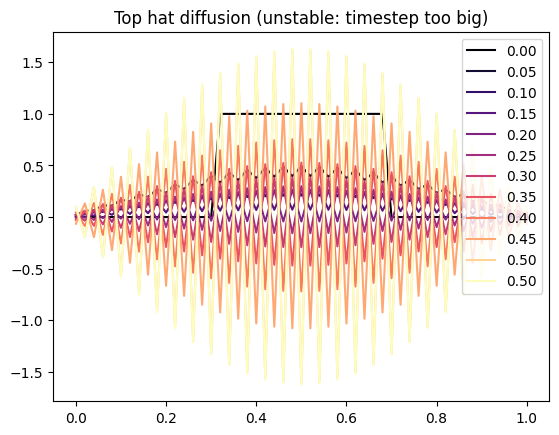

In [5]:
ic = lambda x: (x>.3)*(x<.7)
out = diffusion_FE(ic, k=1, dx=1/50, L=1, dt=2.0034e-4, T=.5, snapshots=10)
plt.title("Top hat diffusion (unstable: timestep too big)")
plot_phis(*out)

Part b

In [6]:
def diffusion_LF(phi_fn, k=1, dx=1, L=100, dt=0.01, T=50, snapshots=[]):
    ''' Diffusion equation dphi/dt = k d^2phi/dx^2
    BC: phi(0) = phi(L) = 0
    
    Given initial condition phi_fn(np.array -> np.array), solve the
    diffusion equation using leaf frog with coef k on domain [0,L]
    with grid space dx. Simulate to time T with timestep dt. Save
    extra snapshots as a list of indices.'''
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)

    # Time and space axis
    t_list = np.arange(0, T, dt*2, dtype=np.float64)
    x = np.arange(0, L+dx, dx, dtype=np.float64)
    
    # IC: Step forward once
    _, _, phi = diffusion_FE(phi_fn, k, dx, L, dt, dt*2, snapshots=[0, 1])

    phi_list = []
    ts = []
    
    n = len(x)
    dtdx = 2*k*dt/dx**2
    
    # Matrix for Leapfrog
    M = (1-2*dtdx)*np.identity(n) + \
        dtdx*np.diag([1]*(n-1), 1) + \
        dtdx*np.diag([1]*(n-1), -1)
    
    # Enforce BC
    M[0,0], M[n-1,n-1] = 0., 0.

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi[0])
            ts.append(t)
        phi[0] = M@phi[0]  # First leapfrog step
        phi[1] = M@phi[1]  # Second leapfrog step

    if t not in ts:  # Save last snapshot
        phi_list.extend(phi)
        ts.extend([t-dt, t])
    return x, ts, phi_list

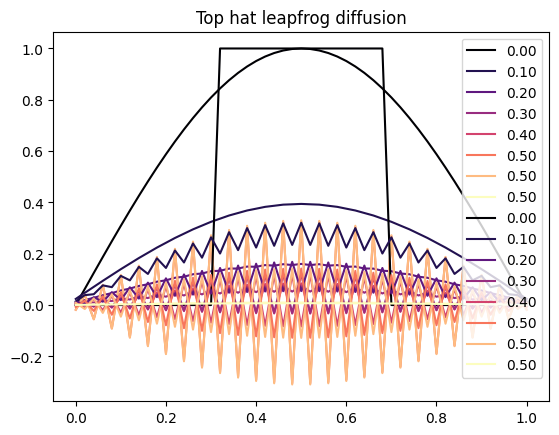

In [7]:
ic = lambda x: np.sin(np.pi*x)
out = diffusion_LF(ic, k=1, dx=1/50, L=1, dt=1.0026e-4, T=.5, snapshots=10)
plt.title("Sin leapfrog diffusion")
plot_phis(*out)

ic = lambda x: (x>.3)*(x<.7)
out = diffusion_LF(ic, k=1, dx=1/50, L=1, dt=1.0012e-4, T=.5, snapshots=10)
plt.title("Top hat leapfrog diffusion")
plot_phis(*out)

We see oscilations which indicate stability issues.

## Question 2
part a

Play around with forcing amplitude to find a suitable observable value.

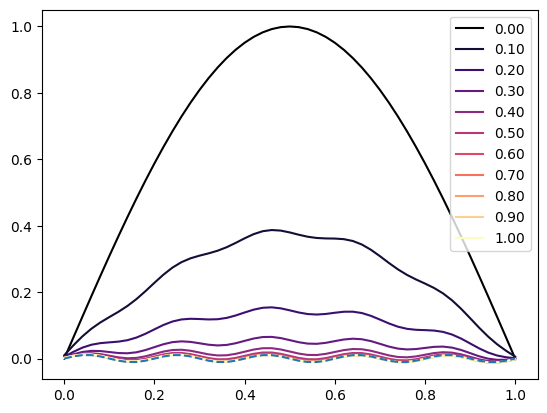

In [8]:
ic = lambda x: np.sin(np.pi*x)
forcing = lambda x, t: 10*np.sin(10*np.pi*x)
out = diffusion_FE(ic, k=1, dx=1/50, L=1, dt=1e-4, T=1, snapshots=10, f=forcing)
plot_phis(*out)
plt.plot(out[0], forcing(out[0], 0)*1e-2*np.e/25, '--', label="Forcing")
plt.show()

## Question 3

Set $\phi(x=1) = \phi(x=1-\Delta x) + \Delta x \frac{\partial \phi}{\partial x}$ at boundary (one sided difference)

In [9]:
def diffusion_FE_Flux(phi_fn, dpLdx=0, k=1, dx=1, L=100, dt=0.01, T=50, snapshots=[], f=None):
    ''' Diffusion equation dphi/dt = k d^2phi/dx^2 + f(x,t) 
    BC: phi(0) = 0,  d/dx phi(L) = dpLdx
    Forcing f
    
    Given initial condition phi_fn(np.array -> np.array), solve the
    diffusion equation using forward Euler with coef k on domain [0,L]
    with grid space dx. Simulate to time T with timestep dt. Save
    extra snapshots as a list of indices.'''
    if dt > dx**2/(2*k):
        print("Unstable, check dt")
    if f is None:
        f = lambda x, t: 0
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, L+dx, dx, dtype=np.float64)
    
    # IC
    phi = np.array(phi_fn(x), dtype=np.float64)
    
    phi_list = []
    ts = []
    
    n = len(x)
    dtdx = k*dt/dx**2
    
    # Matrix for FE
    M = (1-2*dtdx)*np.identity(n) + \
        dtdx*np.diag([1]*(n-1), 1) + \
        dtdx*np.diag([1]*(n-1), -1)
    
    # Enforce BC
    M[0,0] = 0.

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi)
            ts.append(t)
        phi = M@phi  # FE step
        phi[-1] = phi[-2] + dpLdx*dx  # Flux BC
        phi += dt*f(x, t) # Add forcing

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return x, ts, phi_list

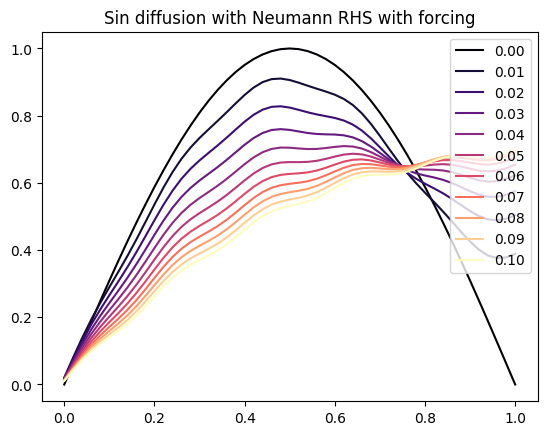

In [10]:
ic = lambda x: np.sin(np.pi*x)
out = diffusion_FE_Flux(ic, dpLdx=.5, k=1, dx=1/50, L=1, dt=1e-4, T=.1, snapshots=10, f=forcing)
plt.title("Sin diffusion with Neumann RHS with forcing")
plot_phis(*out)

part b

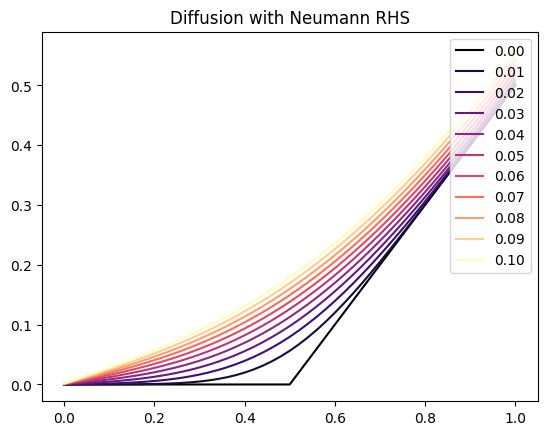

In [11]:
ic = lambda x: (x>.5)*(x-.5)
out = diffusion_FE_Flux(ic, dpLdx=1, k=1, dx=1/50, L=1, dt=1e-4, T=.1, snapshots=10)
plt.title("Diffusion with Neumann RHS")
plot_phis(*out)

## Question 4

In [12]:
def diffusion_2d(ic, k=1, dx=.1, Lx=1, Ly=1, dt=.1, T=1, snapshots=[]):
    '''dx=dy'''
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, Lx+dx, dx, dtype=np.float64)
    y = np.arange(0, Ly+dx, dx, dtype=np.float64)
    xx, yy = np.meshgrid(x, y)

    # IC
    phi = np.array(ic(xx, yy), dtype=np.float64)

    phi_list = []
    ts = []

    nx, ny = len(x), len(y)
    dtdx = k*dt/dx**2

    # Five point Laplacian
    T = -4 * np.identity(nx) + \
        np.diag([1]*(nx-1), 1) + \
        np.diag([1]*(nx-1), -1)
    A = np.kron(np.identity(ny), T) + \
        np.kron(np.diag([1]*(ny-1), 1), np.identity(nx)) + \
        np.kron(np.diag([1]*(ny-1), -1), np.identity(nx))
    A *= dtdx

    def apply_bc(_phi):
        _phi[0, :] = 0
        _phi[-1, :] = 0
        _phi[:, 0] = 0
        _phi[:, -1] = 0
        return _phi

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi.copy())  # Copy to avoid mutable reference
            ts.append(t)
        phi += np.reshape(A@phi.flatten(), (ny, nx))  # FE step
        phi = apply_bc(phi)

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return xx, yy, ts, phi_list
    

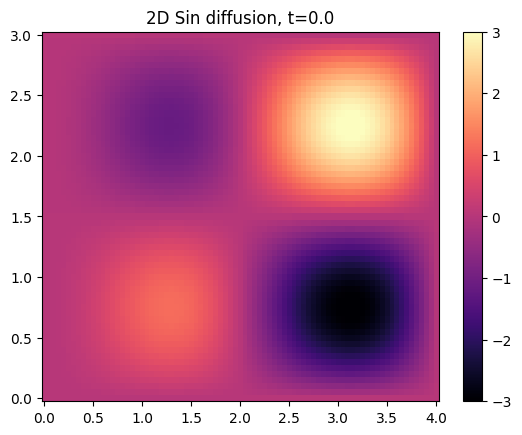

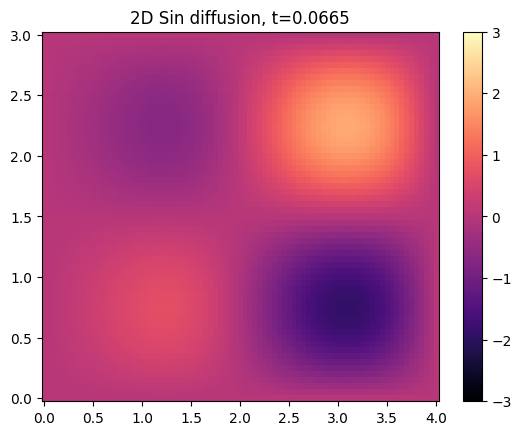

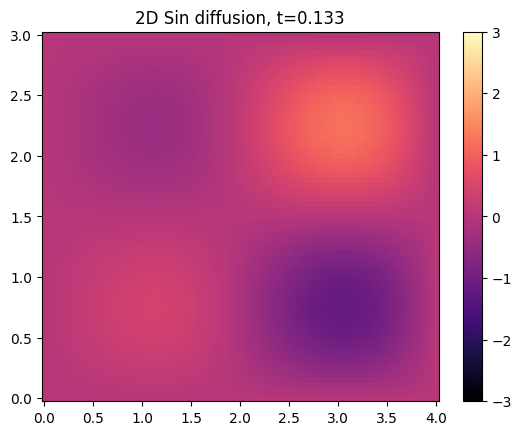

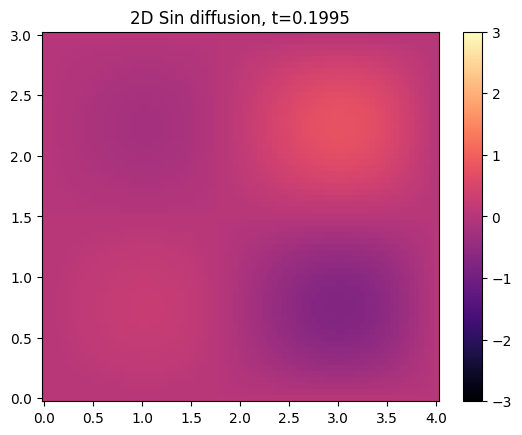

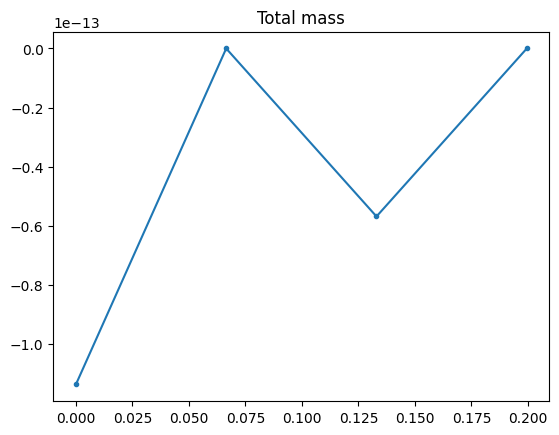

In [13]:
ic = lambda x, y: np.sin(np.pi*x/2)*np.sin(np.pi*y/1.5)*x
xx, yy, ts, phi_list = diffusion_2d(ic, dx=.05, Lx=4, Ly=3, dt=.5e-3, T=.2, snapshots=3)

for i in range(len(ts)):
    plt.pcolormesh(xx, yy, phi_list[i], cmap='magma')
    plt.colorbar()
    plt.clim([-3, 3])
    plt.title(f"2D Sin diffusion, t={ts[i]}")
    plt.show()

plt.plot(ts, [np.sum(phi) for phi in phi_list], '.-')
plt.title("Total mass")
plt.show()


Bonus: No flux Neumann on East using ghost boundary (boundary at Lx-dx/2 etc)

In [14]:
def diffusion_neumann_2d(ic, k=1, dx=.1, Lx=1, Ly=1, dt=.1, T=1, snapshots=[]):
    '''dx=dy
    No flux Neumann using ghost boundary (boundary at Lx-dx/2 etc)'''
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, Lx+dx, dx, dtype=np.float64)
    y = np.arange(0, Ly+dx, dx, dtype=np.float64)
    xx, yy = np.meshgrid(x, y)

    # IC
    phi = np.array(ic(xx, yy), dtype=np.float64)

    phi_list = []
    ts = []

    nx, ny = len(x), len(y)
    dtdx = k*dt/dx**2

    # Five point Laplacian
    T = -4 * np.identity(nx) + \
        np.diag([1]*(nx-1), 1) + \
        np.diag([1]*(nx-1), -1)
    A = np.kron(np.identity(ny), T) + \
        np.kron(np.diag([1]*(ny-1), 1), np.identity(nx)) + \
        np.kron(np.diag([1]*(ny-1), -1), np.identity(nx))
    A *= dtdx

    def apply_bc(_phi):
        _phi[:, -2] += _phi[:, -1]
        _phi[:, 1] += _phi[:, 0]
        _phi[-2, :] += _phi[-1, :]
        _phi[1, :] += _phi[0, :]
        _phi[0, :] = 0
        _phi[-1, :] = 0
        _phi[:, 0] = 0
        _phi[:, -1] = 0
        return _phi

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi.copy())  # Copy to avoid mutable reference
            ts.append(t)
        phi += np.reshape(A@phi.flatten(), (ny, nx))  # FE step
        phi = apply_bc(phi)

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return xx, yy, ts, phi_list
    

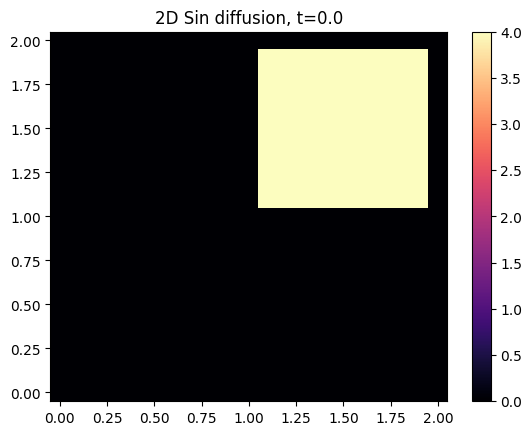

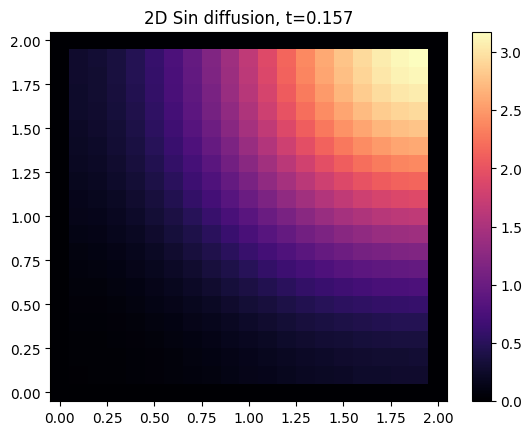

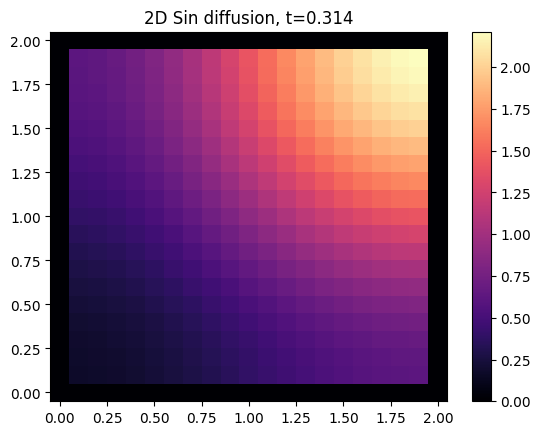

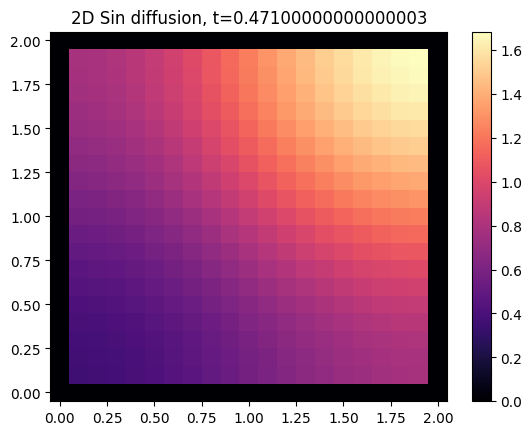

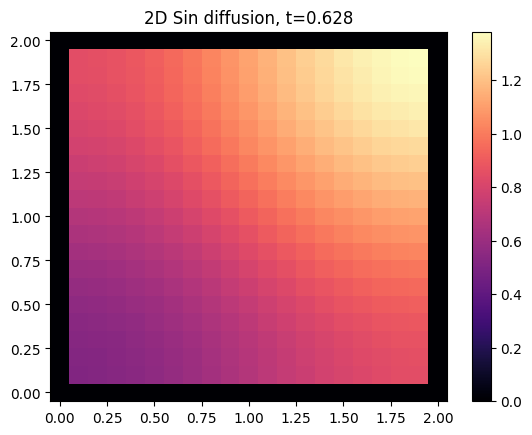

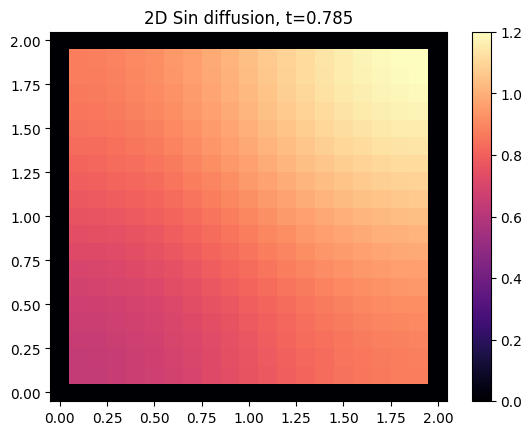

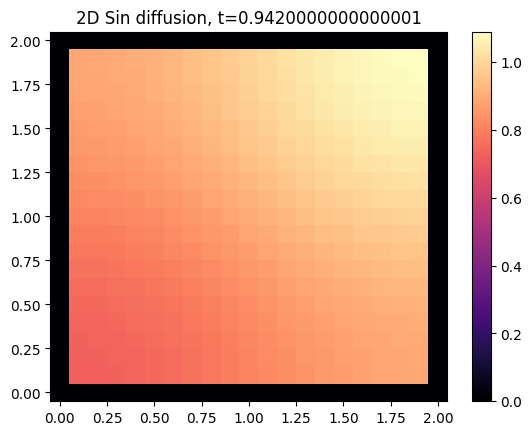

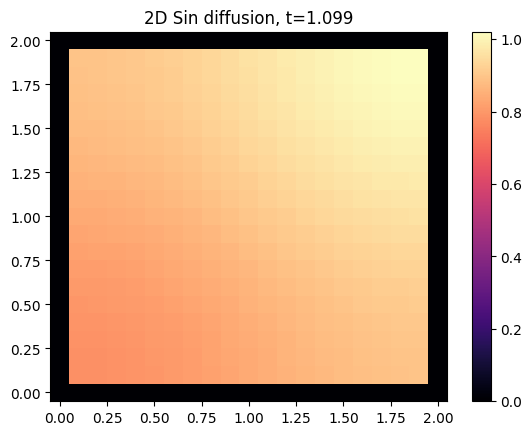

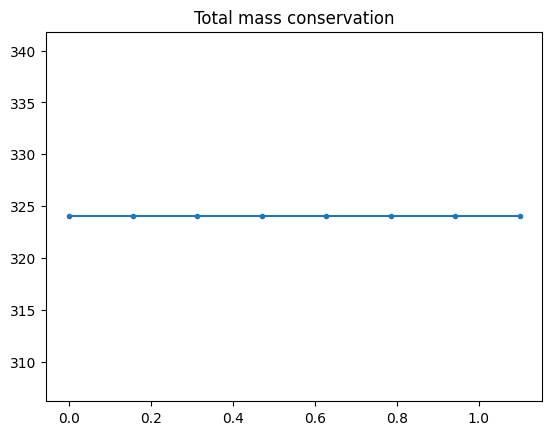

In [15]:
ic = lambda x, y: (x>1) * (y>1) * 4 * (x<2) * (y<2)
xx, yy, ts, phi_list = diffusion_neumann_2d(ic, dx=.1, Lx=2, Ly=2, dt=1e-3, T=1.1, snapshots=7)

for i in range(len(ts)):
    plt.pcolormesh(xx, yy, phi_list[i], cmap='magma')
    plt.colorbar()
    # plt.clim([-1, 1])
    plt.title(f"2D Sin diffusion, t={ts[i]}")
    plt.show()

plt.plot(ts, [np.sum(phi) for phi in phi_list], '.-')
plt.title("Total mass conservation")
plt.show()


Bonus: periodic BC

In [16]:
def diffusion_periodic_2d(ic, k=1, dx=.1, Lx=1, Ly=1, dt=.1, T=1, snapshots=[]):
    '''dx=dy
    Periodic using ghost boundary (boundary at Lx-dx/2 etc)'''
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, Lx+dx, dx, dtype=np.float64)
    y = np.arange(0, Ly+dx, dx, dtype=np.float64)
    xx, yy = np.meshgrid(x, y)

    # IC
    phi = np.array(ic(xx, yy), dtype=np.float64)

    phi_list = []
    ts = []

    nx, ny = len(x), len(y)
    dtdx = k*dt/dx**2

    # Five point Laplacian
    T = -4 * np.identity(nx) + \
        np.diag([1]*(nx-1), 1) + \
        np.diag([1]*(nx-1), -1)
    A = np.kron(np.identity(ny), T) + \
        np.kron(np.diag([1]*(ny-1), 1), np.identity(nx)) + \
        np.kron(np.diag([1]*(ny-1), -1), np.identity(nx))
    A *= dtdx

    def apply_bc(_phi):
        _phi[1, :] += _phi[-1, :]
        _phi[-2, :] += _phi[0, :]
        _phi[:, 1] += _phi[:, -1]
        _phi[:, -2] += _phi[:, 0]
        _phi[0, :] = 0
        _phi[-1, :] = 0
        _phi[:, 0] = 0
        _phi[:, -1] = 0
        return _phi

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi.copy())  # Copy to avoid mutable reference
            ts.append(t)
        phi += np.reshape(A@phi.flatten(), (ny, nx))  # FE step
        phi = apply_bc(phi)

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return xx, yy, ts, phi_list
    

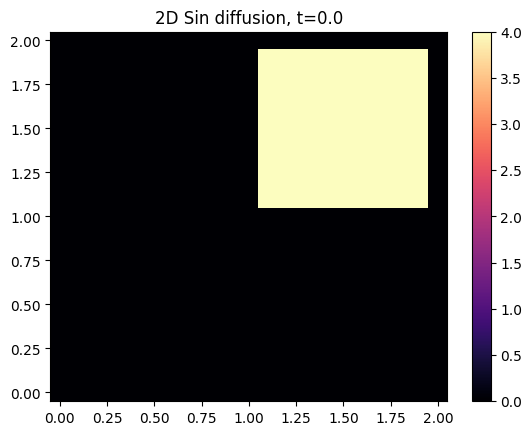

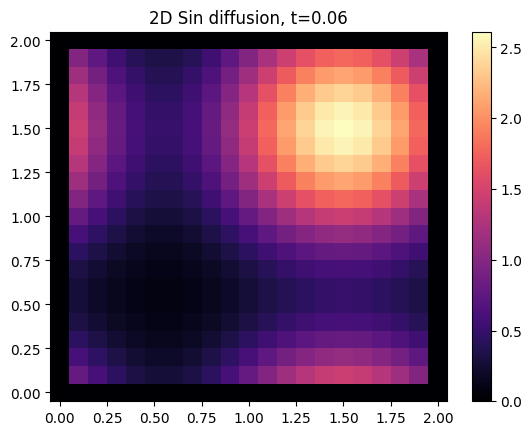

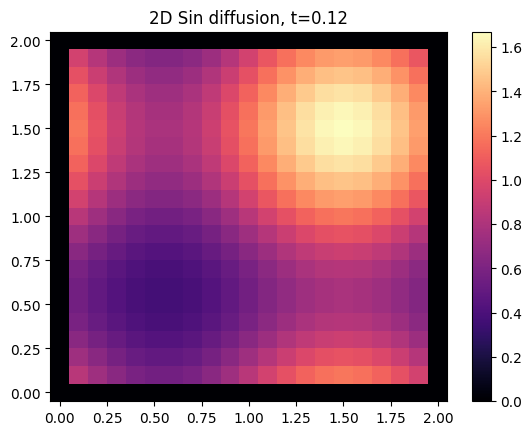

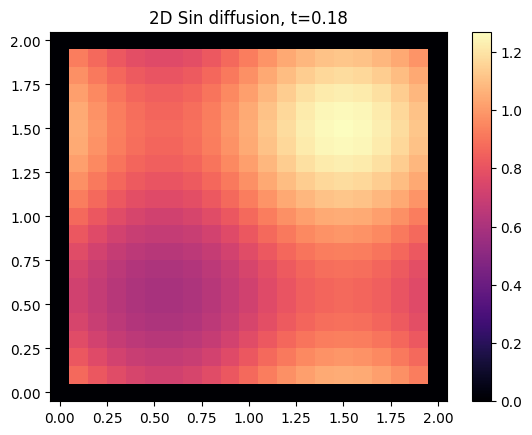

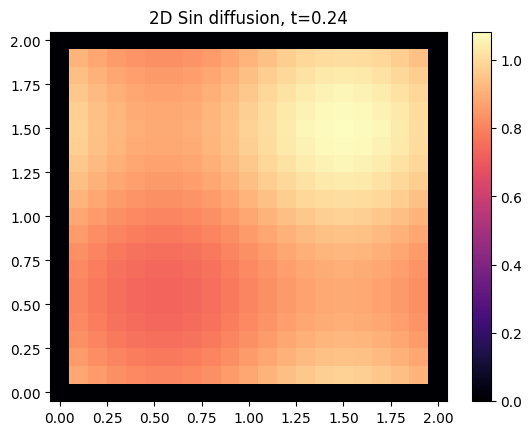

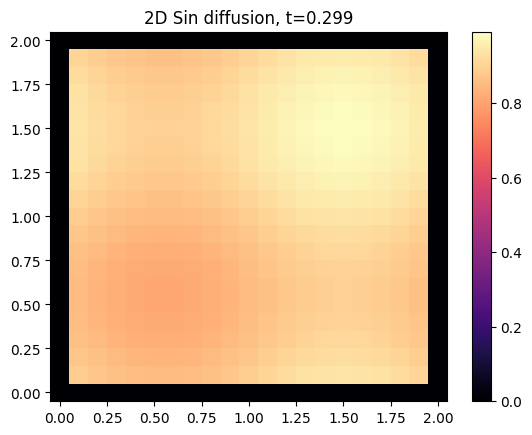

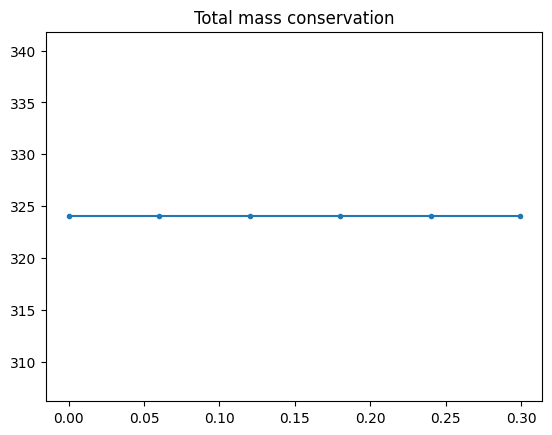

In [17]:
ic = lambda x, y: (x>1) * (y>1) * 4 * (x<2) * (y<2)
xx, yy, ts, phi_list = diffusion_periodic_2d(ic, dx=.1, Lx=2, Ly=2, dt=1e-3, T=.3, snapshots=5)

for i in range(len(ts)):
    plt.pcolormesh(xx, yy, phi_list[i], cmap='magma')
    plt.colorbar()
    # plt.clim([-1, 1])
    plt.title(f"2D Sin diffusion, t={ts[i]}")
    plt.show()

plt.plot(ts, [np.sum(phi) for phi in phi_list], '.-')
plt.title("Total mass conservation")
plt.show()
